In [1]:
%pylab inline

import serial
import serial.tools.list_ports

import time
import numpy as np
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [2]:
for port in serial.tools.list_ports.comports():
    print(port.device)

COM1
COM3


In [3]:
ser = serial.Serial('COM3', 9600)
ser.timeout = 2

In [4]:
ser.isOpen()

True

In [25]:
ser.close()

In [17]:
def sensorRead():
    """Function that takes readings from the light sensor.
    
    """
    lightstr = ser.readline().decode()
    fullstr, irstr = lightstr.strip().split(sep = ' ')
    full = int(fullstr)
    ir = int(irstr)
    visible = full - ir

    return full, ir, visible

In [18]:
def setBackground(integration_time):
    """Function that takes readings of the background light intesity for a certain amount of time.
    
        integration_time (str): A user input for how long a trial should run.
        
        returns:
        backfull(float): the background intensity for full spectrum.
        backir(float): the background intensity for ir.
        backvis(float): the background intensity for visible.
    """
    ser.flushInput()
    
    bfullvals = []
    birvals = []
    bvisvals = []

    start = time.time()
    currenttime = time.time()
    end = (start + integration_time)
    print('Calculating background values...')

    while currenttime < end: 
        bfull, bir, bvis = sensorRead()
    
        bfullvals.append(bfull)
        birvals.append(bir)
        bvisvals.append(bvis)
    
        currenttime = time.time()
    
    backfull = sum(bfullvals) / len(bfullvals)
    backir = sum(birvals) / len(birvals)
    backvis = sum(bvisvals) / len(bvisvals)
    print(backfull)
        
    #print('Background values collected successfully.')
    
    return backfull, backir, backvis

In [19]:
def collect(integration_time):
    """Funtion to take intensity readings over a user input time.
        
        integration_time (str): A user input for how long a trial should run.
        
        return:
        fullvals (list): a list of full spectrum light intensity values.
        irvals (list): a list of ir light intensity values.
        visvals (list): a list of visible light intensity values.
        timevals (list): a list of the time values.
    """
    ser.flushInput()
    
    start = time.time()
    currenttime = time.time()
    end = (start + integration_time)
    
    print("Intensity values being collected...")

    while currenttime < end: 
        full, ir, visible = sensorRead()
    
        fullvals.append(full)
        irvals.append(ir)
        visvals.append(visible)
        
        t = end - currenttime
        timevals.append(t)
        currenttime = time.time()
        
    #print("Intensity values collected successfully.")
        
    return fullvals, irvals, visvals, timevals

In [20]:
def dataValues(integration_time, bfull, bir, bvis):
    """Function that takes collected data and removes the background intensity values.
    
        integration_time (str): A user input for how long a trial should run.
        
        return:
        fullvals (list): a list of full spectrum light intensity values.
        irvals (list): a list of ir light intensity values.
        visvals (list): a list of visible light intensity values.
        timevals (list): a list of the time values.
    """
    
    background = input('Collect background values? ')
    if background == 'Yes':
        bfull, bir, bvis = setBackground(integration_time)
    
    coll = input('Collect intensity values? ')
    if coll == 'Yes':
        fullvals, irvals, visvals, timevals = collect(integration_time)
        
    for i in range(len(fullvals)):
        fullvals[i] -= bfull
    for i in range(len(irvals)):
        irvals[i] -= bir
    for i in range(len(visvals)):
        visvals[i] -= bvis
            
    return fullvals, irvals, visvals, timevals

In [21]:
def average(fullvals, irvals, visvals):
    """Function that takes lists of spectra values and returns the average.
        
        fullvals (list): a list of full spectrum light intensity values.
        irvals (list): a list of ir light intensity values.
        visvals (list): a list of visible light intensity values.
        
        returns:
        fullavg (float): the average values of full spectrum intensity values.
        iravg (float): the average vaules of ir intensity values.
        visavg (float): the average values of visible intensity values.
        """
    
    fullavg = sum(fullvals) / len(fullvals)
    iravg = sum(irvals) / len(irvals)
    visavg = sum(visvals) / len(visvals)
    
    return fullavg, iravg, visavg

In [22]:
def standardDeviation(fullvals, irvals, visvals):
    """Function which give the standard deviation of values.
    
        fullvals (list): a list of full spectrum light intensity values.
        irvals (list): a list of ir light intensity values.
        visvals (list): a list of visible light intensity values.
        
        returns:
        stdfull (float): the standard deviation of the full values list.
        stdir (float): the standard deviation of the ir values list.
        stdvis (float): the standard deviation of the visible values list.
    """
    stdfull = numpy.std(fullvals, ddof=1)
    stdir = numpy.std(irvals, ddof=1)
    stdvis = numpy.std(visvals, ddof=1)
    
    return stdfull, stdir, stdvis

In [23]:
def error(fullvals, irvals, visvals):
    """Function which gives the error of values.
    
    """
    stdfull, stdir, stdvis = standardDeviation(fullvals, irvals, visvals)
    errfull = stdfull / np.sqrt(len(fullvals))
    errir = stdir / np.sqrt(len(irvals))
    errvis = stdvis / np.sqrt(len(visvals))
    
    return errfull, errir, errvis

In [24]:
def timeplot(fullvals, irvals, visvals, timevals):
    """Function which plots spectrum values overtime.
    
        fullvals (list): a list of full spectrum light intensity values.
        irvals (list): a list of ir light intensity values.
        visvals (list): a list of visible light intensity values.
        timevals (list): a list of the time values.
        
        return (plot): a plot of all the spectrum values overtime.
    """

    plt.plot(timevals, fullvals, timevals, irvals, timevals, visvals)
    
    plt.xlabel('Time')
    plt.ylabel('Intensity')
    plt.title('Spectrum Intensity Values')

    plt.legend(['Full Spectrum', 'IR', 'Visible'], loc='upper left')
    
    plt.show()

In [25]:
def csvform(positions, favg, iavg, vavg, ferr, ierr, verr):
    filename = input('Name of File? ') # needs to be csv, ie. filename.csv
    header_row_text = 'Positions, Full, FullError, IR, IRError, Visible, VisibleError'
    comment_text = ''
    
    data = np.array([positions, favg, ferr, iavg, ierr, vavg, verr]).T
    np.savetxt(filename, data, delimiter = ',', header = header_row_text, comments = comment_text)

In [40]:
def mainFunction():
    cont = 'Yes'
    integrate = input("How many seconds should the trials run? ") # Input number of seconds each trial should run
    integration_time = float(integrate)
    
    while cont == 'Yes':
        positionstr = input('Position? ') # For Atomic Spectrum Lab
        position = float(positionstr)
        positions.append(position)
        
        fullvals, irvals, visvals, timevals = dataValues(integration_time, bfull, bir, bvis)
        fullavg, iravg, visavg = average(fullvals, irvals, visvals)
        print(fullavg)
        errfull, errir, errvis = error(fullvals, irvals, visvals)
        
        
        favg.append(fullavg)
        iavg.append(iravg)
        vavg.append(visavg)
        
        ferr.append(errfull)
        ierr.append(errir)
        verr.append(errvis)
        #print('Averages and error calculated.')
        
        fullvals.clear()
        irvals.clear()
        visvals.clear()
        timevals.clear()
        
        cont = input('Continue collecting averages? ')
        print()
        if cont == 'No':
            break
        
    
    #figure = timeplot(fullvals, irvals, visvals, timevals)
    csvfile = csvform(positions, favg, iavg, vavg, ferr, ierr, verr)

In [49]:
bfull = 0
bir = 0
bvis = 0

In [50]:
fullvals = []
irvals = []
visvals = []
timevals = []

In [51]:
positions = [] # For Atomic Spectra Lab

favg = []
iavg = []
vavg = []
    
ferr = []
ierr = []
verr = []

In [19]:
integrate = input('Integrate?')
integration_time = float(integrate)

Integrate?30


In [23]:
full, ir, vis, timevals = dataValues(integration_time, bfull, bir, bvis)

Collect background values? Yes
Calculating background values...
8327.83076923077
Collect intensity values? Yes
Intensity values being collected...


In [24]:
fullavg, iravg, visavg = average(fullvals, irvals, visvals)

In [25]:
print(fullavg)

-12.723076923077567


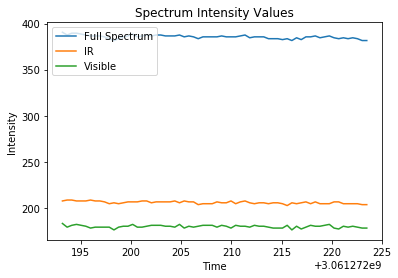

In [74]:
figure = timeplot(full, ir, vis, timevals)

In [48]:
ser.flushInput()

In [52]:
# Atomic Spectra Lab
mainFunction()

How many seconds should the trials run? 30
Position? 0
Collect background values? Yes
Calculating background values...
3067.5384615384614
Collect intensity values? Yes
Intensity values being collected...
-1.599999999999895
Continue collecting averages? Yes

Position? 0
Collect background values? Yes
Calculating background values...
3065.9692307692308
Collect intensity values? Yes
Intensity values being collected...
-0.6461538461538392
Continue collecting averages? Yes

Position? 0
Collect background values? Yes
Calculating background values...
3064.9848484848485
Collect intensity values? Yes
Intensity values being collected...
-1.1079254079254217
Continue collecting averages? No

Name of File? finishedtest
